# Program preparation
## Imports

In [64]:
import numpy as np # library used for work with arrays
import cv2 # бібліотека для роботи з комп'ютерним зором
from matplotlib import pyplot as plt # library used for creating and displaying images

## Necessary constants

In [65]:
source_dir = "test/" # image directories
image_filenames = ['1.bmp', '2.bmp', '3.bmp', '4.bmp'] # images which represent recognition classes
big_image = "test/intel.jpg" # big image
output_path = "classified_image.jpg" # Зберегти результуюче зображення
class_names = ['A', 'B', 'C', 'D'] # class names
# Кольори для позначення кожного класу
# Червоний, Зелений, Блакитний, Пурпуровий, Білий
class_colors = [(255, 0, 0), (0, 255, 0), (0, 255, 255), (255, 0, 255), (255, 255, 255)]
class_block_size = 50 # розмір області класифікації
ro = 0.5 # Initialize boundary value ro, which is equal to 0.5
kulbak_lambda = 2 # значення lambda

## Functions

In [66]:
# Функція отримання контрольних допусків
def find_control_tolerance_vector(pixel_values):
    return [np.mean([row[i] for row in pixel_values]) for i in range(len(pixel_values[0]))]

In [67]:
# Функція отримання бінарної матриці на основі СКД
def create_binary_matrix(pixel_values, control_tolerance_vector, delta):
    return [
        [
            1 if control_tolerance_vector[i] - delta <= val <= control_tolerance_vector[i] + delta 
            else 0
            for i, val in enumerate(row)
        ]
        for row in pixel_values
    ]

In [68]:
# Функція отримання еталонного вектору
def create_etalon_vector(binary_matrix):
    return np.array(binary_matrix).mean(axis=1) > ro

In [69]:
# Функція обчислення відстані між двома векторами
def calculate_vector_distance(vector_1, vector_2):
    return np.sum(np.logical_xor(vector_1, vector_2))

In [70]:
# Функція пошуку пар сусідніх класів для кожного класу
def find_neighbors(etalon_vectors, classes):
    # Знаходимо пари сусідніх класів для кожного класу
    neighbor_pairs = [[len(etalon_vectors[0]) + 1, len(etalon_vectors[0]) + 1] for _ in etalon_vectors]
    for i, vector_1 in enumerate(etalon_vectors):
        for j, vector_2 in enumerate(etalon_vectors):
            if i != j: # якщо класи відрізняються
                # шукаємо відстань між 2 класами
                distance = calculate_vector_distance(vector_1, vector_2)
                # якщо дистанція є меншою за існуючий результат
                if distance < neighbor_pairs[i][1]:
                    # змінюємо результат на новий
                    neighbor_pairs[i] = [j, distance]
    # виводимо фінальний результат знаходження класів-сусідів
    print("Base class | Neighbor class | Distance")
    for i, (j, distance) in enumerate(neighbor_pairs):
        print(f"{class_names[classes[i]]} \t   | {class_names[classes[j]]} \t\t    | {distance}")
    return neighbor_pairs

In [71]:
# Функція розрахунку критерію Кульбака
def calculate_kulbak(alpha, beta, d1, d2):
    return (0.5 * np.log2((d1 + d2 + 10 ** (-kulbak_lambda)) / (alpha + beta + 10 ** (-kulbak_lambda)))) * ((d1 + d2) - (alpha + beta))

In [72]:
# Функція обчислення значення критерію для кожного класу і радіуса
def compute_criteria(etalon_vectors, binary_matrices, neighbor_pairs):
    # Ініціалізуємо масив отриманих критеріїв
    criteria_results = [[] for _ in etalon_vectors]

    for class_number in range(len(etalon_vectors)):
        for radius in range(101):
            # Кодова відстань для базового класу
            sk = [calculate_vector_distance(etalon_vectors[class_number], binary_row) 
                for binary_row in binary_matrices[class_number]]
            # Кодова відстань для класу-сусіда
            sk_para = [calculate_vector_distance(etalon_vectors[class_number], binary_row) 
                for binary_row in binary_matrices[neighbor_pairs[class_number][0]]]
            # Перша достовірність
            d1 = np.mean([1 if distance <= radius else 0 for distance in sk])
            # Помилка другого роду
            beta = np.mean([1 if distance <= radius else 0 for distance in sk_para])
            # Помилка першого роду
            alpha = 1 - d1
            # Друга достовірність
            d2 = 1 - beta
            # пошук значення критерію Кульбака
            criteria_value = calculate_kulbak(alpha, beta, d1, d2) / calculate_kulbak(0, 0, 1, 1)
            # Перевірка, чи лежить отримане значення в межах робочої області
            is_within_working_area = d1 >= 0.5 > beta
            criteria_results[class_number].append((criteria_value, is_within_working_area, d1, beta))

    return criteria_results

In [73]:
# Функція пошуку оптимальної дельти для СКД
def find_delta(pixel_values, classes):
    # установлюємо початкове значення для delta
    optimal_delta = 0
    # установлюємо початкове значення для критерію
    best_criteria_value = 0
    # Масиви, які будуть використані для побудови графіка
    deltas = []
    criteria_values = []
    criteria_values_work_area = []

    print("Calculation of the optimal delta")

    # Перевіряємо дельту в діапазоні від 1 до 116
    for delta in range(1, 117):
        deltas.append(delta)
        print("For delta " + str(delta))
        # ініціалізуємо масив для бінарних матриць
        binary_matrices = []
        # ініціалізуємо масив для еталонних векторів
        etalon_vectors = []
        # шукаємо значення для масиву контрольних допусків
        control_tolerance_vector = find_control_tolerance_vector(pixel_values[0])

        # Створюємо бінарні матриці для кожного класу та їх еталонні вектори
        for values in pixel_values:
            binary_matrix = create_binary_matrix(values, control_tolerance_vector, delta)
            binary_matrices.append(binary_matrix)
        
        # ініціалізуємо масив для еталонних векторів
        etalon_vectors = create_etalon_vector(binary_matrices)

        # Пошук класів сусідів
        neighbor_pairs = find_neighbors(etalon_vectors, classes)
        # Пошук інформаційного критерію
        criteria_results = compute_criteria(etalon_vectors, binary_matrices, neighbor_pairs)

        # Перевіряємо наявність робочих областей
        working_area_values = [max([pair[0] for pair in result if pair[1]], default=0)
                               for result in criteria_results]

        # Обчислюємо середнє значення критерію та оновлюємо оптимальну дельту
        current_value = np.mean(working_area_values)
        if current_value > best_criteria_value:
            optimal_delta = delta
            best_criteria_value = current_value

        criteria_values.append(np.mean([max([pair[0] for pair in result], default=0)
                              for result in criteria_results]));
        criteria_values_work_area.append(current_value if current_value > 0 else -1);

        print("Delta | criteria value | criteria value in working area")
        print(delta, " | ", np.mean([max([pair[0] for pair in result], default=0)
                              for result in criteria_results]), " | ",
              current_value if current_value > 0 else -1)

    # Побудова графіка
    # Фільтрація значень
    filtered_criteria_values = [cv if cv >= 0 and not np.isinf(cv) else np.nan for cv in criteria_values]
    filtered_criteria_values_work_area = [cva if cva >= 0 and not np.isinf(cva) else np.nan for cva in criteria_values_work_area]

    # Створення маски для збігання значень
    overlap_exact = [
        cv if cv == cva and not (np.isnan(cv) or np.isnan(cva)) else np.nan
        for cv, cva in zip(filtered_criteria_values, filtered_criteria_values_work_area)
    ]

    plt.figure(figsize=(10, 6))
    
    # Заповнення області для Criteria Values
    plt.fill_between(deltas, 0, filtered_criteria_values, 
                     where=[not np.isnan(cv) for cv in filtered_criteria_values], 
                     color='blue', alpha=0.3, label='Kulbak Criteria Values Area')
    
    # Заповнення області для Criteria Values (Working Area)
    plt.fill_between(deltas, 0, filtered_criteria_values_work_area, 
                     where=[not np.isnan(cva) for cva in filtered_criteria_values_work_area], 
                     color='green', alpha=0.3, label='Working Area')

    # Виділення області точного збігання значень
    plt.fill_between(deltas, 0, overlap_exact, 
                     where=[not np.isnan(oe) for oe in overlap_exact], 
                     color='red', alpha=0.5, label='Exact Match Area')
    
    # Лінія для оптимальної delta
    plt.axvline(x=optimal_delta, color='red', linestyle='--', label=f'Optimal Delta = {optimal_delta}')

    plt.xlabel("Delta")
    plt.ylabel("Kulbak Criteria Value")
    plt.title("Dependency of Kulbak Criteria Values on Delta (with Exact Match Area)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Optimal delta: ", optimal_delta)
    return optimal_delta

In [74]:
def find_class_optimal_radius(etalon_vectors, binary_matrices, classes):
    # Пошук класів сусідів
    neighbor_pairs = find_neighbors(etalon_vectors, classes)
    # Пошук інформаційного критерію
    criteria_results = compute_criteria(etalon_vectors, binary_matrices, neighbor_pairs)

    # Масив для збереження оптимальних радіусів для кожного класу
    class_radius = []
    print("Calculation of radius for classes")
    for i, result in enumerate(criteria_results):
        # Масиви для використання в графіку залежності критерію Кульбака від радіусу
        # Для кожного класу
        is_working_area_set = []
        radiuses = []
        criteria_result_set = []

        print("Class ", class_names[classes[i]])
        print("Is working area | radius | criteria value | d1 | beta")

        best_radius = -1
        best_value = -1
        # Проходимо по всім радіусам та знаходимо оптимальний
        for j, pair in enumerate(result):
            is_working_area_set.append(pair[1])
            radiuses.append(j)
            criteria_result_set.append(pair[0])
            print(pair[1], j, pair[0], pair[2], pair[3])
            if pair[1] and pair[0] > best_value:
                best_value = pair[0]
                best_radius = j
        if best_radius == -1:
            best_radius = 1  # Якщо не знайдено, використовуємо мінімальний радіус

        # Основна область критерію
        plt.fill_between(radiuses, criteria_result_set, color="skyblue", alpha=0.4, label="Kulbak Criteria Value")
        plt.plot(radiuses, criteria_result_set, color="blue", label="Kulbak Criteria Value (line)")
        
        # Область робочої зони
        working_radiuses = np.array(radiuses)[is_working_area_set]
        working_criteria = np.array(criteria_result_set)[is_working_area_set]
        plt.fill_between(working_radiuses, working_criteria, color="green", alpha=0.3, label="Working Area")
        
        # Відображаємо оптимальний радіус на графіку
        plt.axvline(x=best_radius, color="red", linestyle="--", label=f"Optimal Radius = {best_radius}")
        
        plt.title(f"Dependency of Kulbak Criteria Values on Radius for Class {class_names[classes[i]]}")
        plt.xlabel("Radius")
        plt.ylabel("Kulbak Criteria Value")
        plt.legend()
        plt.grid()
        plt.show()

        class_radius.append(best_radius)

    return class_radius

In [75]:
def examine_region(etalon_vector, radius, binary_matrix):
    # Порівняння області з еталонним вектором
    if radius == 0:
        return 0  # Уникаємо ділення на нуль
    result = np.mean([1 - (calculate_vector_distance(etalon_vector, binary_row) / radius)
                     for binary_row in binary_matrix])
    return result

In [76]:
# Функція екзамену зображення
def exam_algorithm(image, colors, block_size, delta1, delta2, control_tolerance_vector1, 
                   control_tolerance_vector2, etalon_vectors1, etalon_vectors2, radius1, radius2,
                   classes1, classes2):
    image_height, image_width, _ = image.shape

    # Створення копії для відображення результатів класифікації
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_image = image.copy()
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Встановлення параметрів шрифту
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2

    recognized_blocks = [0,0,0,0,0]
    # Проходимо по кожній області (квадрат) в зображенні
    for i in range(0, image_width, block_size):
        for j in range(0, image_height, block_size):
            try:
                # Вирізаємо область та класифікуємо її
                crop = image[j:j + block_size, i:i + block_size]
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                crop_values = crop.reshape(*crop.shape[:-2], -1)
                crop_binary_matrix1 = create_binary_matrix(crop_values, control_tolerance_vector1, delta1)
                crop_binary_matrix2 = create_binary_matrix(crop_values, control_tolerance_vector2, delta2)

                class_index = -1
                highest_value = 0

                print("Class name | Belonging Function Value")
                # Проводимо порівняння області з еталонами кожного класу
                for k, etalon_vector in enumerate(etalon_vectors1):
                    result = examine_region(etalon_vector, radius1[k], crop_binary_matrix1)
                    print(f"{class_names[classes1[k]]} \t   | {result}")
                    if result > highest_value:
                        class_index = classes1[k]
                        highest_value = result
                    
                for k, etalon_vector in enumerate(etalon_vectors2):
                    result = examine_region(etalon_vector, radius2[k], crop_binary_matrix2)
                    print(f"{class_names[classes2[k]]} \t   | {result}")
                    if result > highest_value:
                        class_index = classes2[k]
                        highest_value = result

                # Додаємо текст
                text_position = (i + 3, j + 20)
                # Якщо область класифікована, позначаємо її номером класу та кольором
                if class_index != -1:
                    recognized_blocks[class_index] += 1
                    # У текст додаємо 
                    cv2.putText(output_image, class_names[class_index], text_position, font, font_scale,
                                colors[class_index], font_thickness)

                    # Малюємо прямокутник навколо області
                    top_left = (i + 1, j + 1)
                    bottom_right = (i + block_size - 1, j + block_size - 1)
                    cv2.rectangle(output_image, top_left, bottom_right, colors[class_index], 3)
                else:
                    recognized_blocks[4] += 1
                    cv2.putText(output_image, "N/I", text_position, font, font_scale,
                                colors[4], font_thickness)
                    
                    # Малюємо прямокутник навколо області
                    top_left = (i + 1, j + 1)
                    bottom_right = (i + block_size - 1, j + block_size - 1)
                    cv2.rectangle(output_image, top_left, bottom_right, colors[4], 3)

            except Exception as e:
                print(e)

    print("Recognized blocks:")
    print("Class A: ", recognized_blocks[0])
    print("Class B: ", recognized_blocks[1])
    print("Class C: ", recognized_blocks[2])
    print("Class D: ", recognized_blocks[3])
    print("Unrecognized: ", recognized_blocks[4])

    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    # Збереження результатів класифікації
    cv2.imwrite(output_path, output_image)
    print(f"Success! Classified image saved to {output_path}.")

## Decursive binary tree

In [77]:
# Клас для вузла декурсивного бінарного дерева
class TreeNode:
    def __init__(self, matrix=None, left=None, right=None, classes=None):
        """
        :param matrix: Навчальна матриця (еталон вузла)
        :param left: Ліва гілка
        :param right: Права гілка
        :param classes: Індекси класів розпізнавання в цій групі
        """
        self.matrix = matrix
        self.left = left
        self.right = right
        self.classes = classes  # Вузли, що належать цьому рівню

# Основна функція побудови декурсивного дерева
def build_recursive_binary_tree(average_brightness, Y_data, classes):
    """
    Рекурсивна побудова дерева за схемою декурсивного бінарного дерева.
    """
    if len(average_brightness) == 0:
        return None

    if len(average_brightness) == 1:
        # Якщо залишився лише один клас, створюємо листковий вузол
        return TreeNode(matrix=Y_data[0], classes=classes)

    # Розбиваємо варіаційний ряд
    left_group, right_group = split_variational_series(average_brightness, Y_data)

    # Рекурсивно будуємо дочірні вузли
    left_node = build_recursive_binary_tree(left_group[0], left_group[1], classes[:len(left_group[0])])
    right_node = build_recursive_binary_tree(right_group[0], right_group[1], classes[len(left_group[0]):])

    # Сукупна матриця для вузла — це всі матриці, які належать цьому вузлу
    combined_matrix = np.vstack((left_group[1], right_group[1]))

    # Створюємо вузол із дочірніми гілками
    return TreeNode(matrix=combined_matrix, left=left_node, right=right_node, classes=classes)

# Функція для розбиття варіаційного ряду
def split_variational_series(average_brightness, Y_data):
    """
    Поділ варіаційного ряду на дві групи.
    """
    mid_idx = len(average_brightness) // 2
    left_group = (average_brightness[:mid_idx], Y_data[:mid_idx])
    right_group = (average_brightness[mid_idx:], Y_data[mid_idx:])
    return left_group, right_group

# Виведення дерева у вигляді тексту
def print_tree(node, depth=0):
    if node is None:
        return
    print("  " * depth + f"Node: classes={node.classes}, matrix_shape={node.matrix.shape}")
    print_tree(node.left, depth + 1)
    print_tree(node.right, depth + 1)

# Start
## Displaying the big image

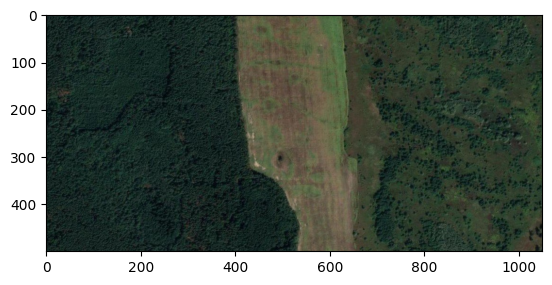

In [78]:
# opening and displaying the big image
image = cv2.imread(big_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1)
ax.imshow(image)

## Filling of the array

In [79]:
# filling of the array with images
images = np.array([np.asarray(cv2.cvtColor(cv2.imread(source_dir+p), cv2.COLOR_BGR2RGB)) for p in image_filenames])

## Transformation of the array and creation of the decursive binary tree

In [80]:
# Transformation the array of implementations from 2D to 1D
Y = images.reshape(*images.shape[:-2], -1)
# Обчислення середньої яскравості для кожного класу
average_brightness_per_class = Y.mean(axis=(1, 2))

# Сортування за середньою яскравістю
sorted_indices = np.argsort(average_brightness_per_class)  # Індекси у порядку зростання
Y_sorted = Y[sorted_indices]  # Сортування масиву Y
images_sorted = images[sorted_indices]  # Сортування масиву images
average_brightness_sorted = average_brightness_per_class[sorted_indices]  # Сортування значень яскравості

# Виведення результатів після сортування
print("Результати:")
for i, brightness in enumerate(average_brightness_sorted):
    print(f"Клас {i + 1}: середня яскравість = {brightness:.2f}")

# Побудова дерева
root = build_recursive_binary_tree(average_brightness_sorted, Y_sorted, np.array([0, 1, 2, 3]))

# Виведення дерева
print("Декурсивне бінарне дерево:")
print_tree(root)

Результати:
Клас 1: середня яскравість = 30.55
Клас 2: середня яскравість = 41.97
Клас 3: середня яскравість = 59.14
Клас 4: середня яскравість = 87.82
Декурсивне бінарне дерево:
Node: classes=[0 1 2 3], matrix_shape=(4, 50, 150)
  Node: classes=[0 1], matrix_shape=(2, 50, 150)
    Node: classes=[0], matrix_shape=(50, 150)
    Node: classes=[1], matrix_shape=(50, 150)
  Node: classes=[2 3], matrix_shape=(2, 50, 150)
    Node: classes=[2], matrix_shape=(50, 150)
    Node: classes=[3], matrix_shape=(50, 150)


## Images displaying

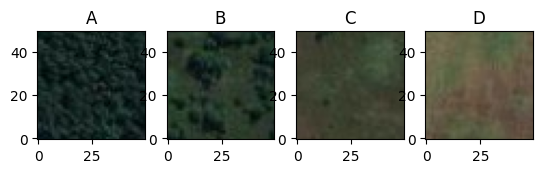

In [81]:
# creation of plot surface where
# the array of images will be displayed horizontally
fig, axes = plt.subplots(1,4)

for i, ax in enumerate(axes):
    ax.set_title(class_names[i]) # setting title to each image
    ax.imshow(images_sorted[i], origin="lower")  # image displaying using imshow

# Binary realizations

## Calculation of control bounds

Calculation of the optimal delta
For delta 1
Base class | Neighbor class | Distance
A 	   | B 		    | 0
B 	   | A 		    | 0
Delta | criteria value | criteria value in working area
1  |  0.10233752564755488  |  0.05116876282377744
For delta 2
Base class | Neighbor class | Distance
A 	   | B 		    | 0
B 	   | A 		    | 0
Delta | criteria value | criteria value in working area
2  |  0.24247464038773603  |  0.12123732019386801
For delta 3
Base class | Neighbor class | Distance
A 	   | B 		    | 0
B 	   | A 		    | 0
Delta | criteria value | criteria value in working area
3  |  0.3017883127366328  |  0.1508941563683164
For delta 4
Base class | Neighbor class | Distance
A 	   | B 		    | 0
B 	   | A 		    | 0
Delta | criteria value | criteria value in working area
4  |  0.35022287321081835  |  0.17511143660540918
For delta 5
Base class | Neighbor class | Distance
A 	   | B 		    | 0
B 	   | A 		    | 0
Delta | criteria value | criteria value in working area
5  |  0.40914680094099404  |  0.20

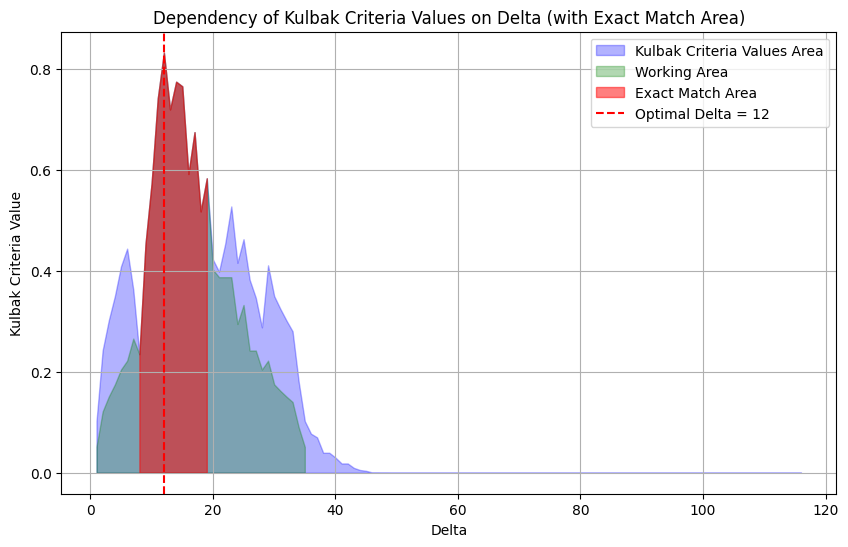

Optimal delta:  12
Calculation of the optimal delta
For delta 1
Base class | Neighbor class | Distance
C 	   | D 		    | 0
D 	   | C 		    | 0
Delta | criteria value | criteria value in working area
1  |  1.0  |  0.5
For delta 2
Base class | Neighbor class | Distance
C 	   | D 		    | 5
D 	   | C 		    | 5
Delta | criteria value | criteria value in working area
2  |  1.0  |  0.5
For delta 3
Base class | Neighbor class | Distance
C 	   | D 		    | 57
D 	   | C 		    | 57
Delta | criteria value | criteria value in working area
3  |  0.5558219048660388  |  0.5558219048660388
For delta 4
Base class | Neighbor class | Distance
C 	   | D 		    | 104
D 	   | C 		    | 104
Delta | criteria value | criteria value in working area
4  |  1.0  |  1.0
For delta 5
Base class | Neighbor class | Distance
C 	   | D 		    | 123
D 	   | C 		    | 123
Delta | criteria value | criteria value in working area
5  |  1.0  |  1.0
For delta 6
Base class | Neighbor class | Distance
C 	   | D 		    | 133
D 	   | C 

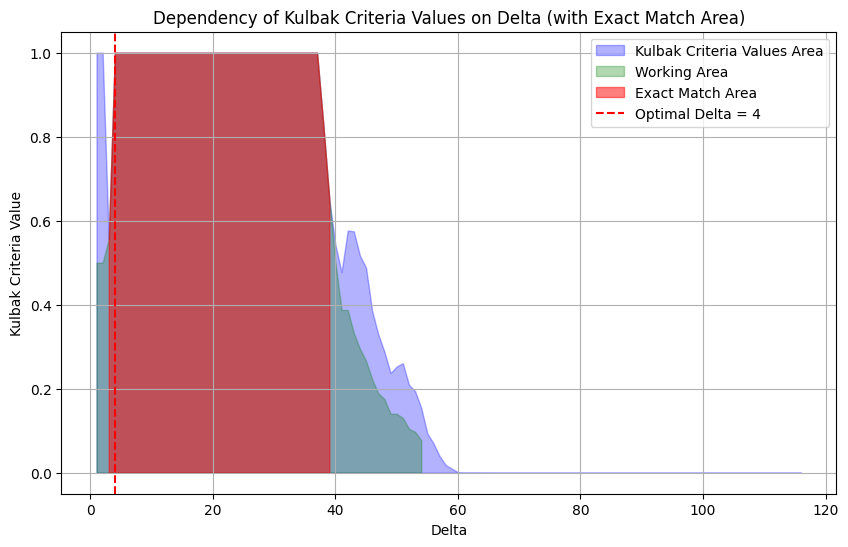

Optimal delta:  4


In [82]:
delta1 = find_delta(root.left.matrix, root.left.classes) # Value, which defines the range from the average, for the left node
delta2 = find_delta(root.right.matrix, root.right.classes) # Value, which defines the range from the average, for the right node
# Calculation of the control bounds
EV1 = find_control_tolerance_vector(root.left.matrix[0])
EV2 = find_control_tolerance_vector(root.right.matrix[0])

## Calculation of binary realizations

In [83]:
X_left = []
X_right = []
for values in root.left.matrix:
    binary_matrix = create_binary_matrix(values, EV1, delta1)
    X_left.append(binary_matrix)

for values in root.right.matrix:
    binary_matrix = create_binary_matrix(values, EV2, delta2)
    X_right.append(binary_matrix)

# Calculation of optimal radius and exam algorithm

Etalon vectors for left node:
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True False  True False  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [False False  True False False  True False

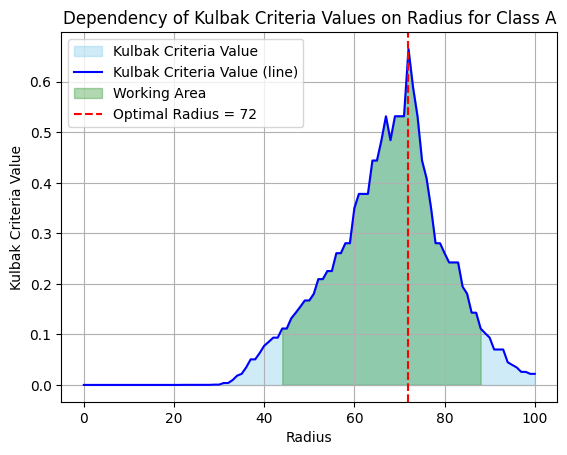

Class  B
Is working area | radius | criteria value | d1 | beta
False 0 0.0 0.0 0.0
False 1 0.0 0.0 0.0
False 2 0.0 0.0 0.0
False 3 0.0 0.0 0.0
False 4 0.0 0.0 0.0
False 5 0.0 0.0 0.0
False 6 0.0 0.0 0.0
False 7 0.0 0.0 0.0
False 8 0.0 0.0 0.0
False 9 0.0 0.0 0.0
False 10 0.0 0.0 0.0
False 11 0.0 0.0 0.0
False 12 0.0 0.0 0.0
False 13 0.0 0.0 0.0
False 14 0.0 0.0 0.0
False 15 0.0 0.0 0.0
False 16 0.0 0.0 0.0
False 17 0.0 0.0 0.0
False 18 0.0 0.0 0.0
False 19 0.0 0.0 0.0
False 20 0.0 0.0 0.0
False 21 0.0 0.0 0.0
False 22 0.0 0.0 0.0
False 23 0.0 0.0 0.0
False 24 0.0 0.0 0.0
False 25 0.0 0.0 0.0
False 26 0.0 0.0 0.0
False 27 0.0 0.0 0.0
False 28 0.0005977357367004173 0.04 0.0
False 29 0.0005977357367004173 0.04 0.0
False 30 0.0005977357367004173 0.04 0.0
False 31 0.0013457865793905495 0.06 0.0
False 32 0.00239470883651662 0.08 0.0
False 33 0.00239470883651662 0.08 0.0
False 34 0.00239470883651662 0.08 0.0
False 35 0.00239470883651662 0.08 0.0
False 36 0.005402324470178281 0.12 0.0
False 37

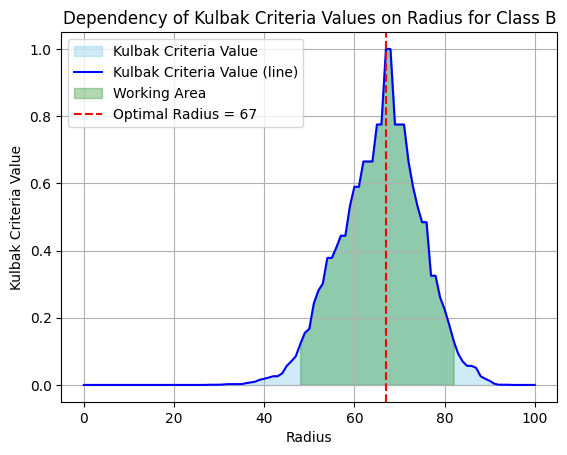

Base class | Neighbor class | Distance
C 	   | D 		    | 104
D 	   | C 		    | 104
Calculation of radius for classes
Class  C
Is working area | radius | criteria value | d1 | beta
False 0 0.0 0.0 0.0
False 1 0.0 0.0 0.0
False 2 0.0 0.0 0.0
False 3 0.0 0.0 0.0
False 4 0.0 0.0 0.0
False 5 0.0 0.0 0.0
False 6 0.0 0.0 0.0
False 7 0.0 0.0 0.0
False 8 0.0 0.0 0.0
False 9 0.0 0.0 0.0
False 10 0.0 0.0 0.0
False 11 0.0 0.0 0.0
False 12 0.0 0.0 0.0
False 13 0.0 0.0 0.0
False 14 0.0 0.0 0.0
False 15 0.0 0.0 0.0
False 16 0.0 0.0 0.0
False 17 0.0 0.0 0.0
False 18 0.0 0.0 0.0
False 19 0.0 0.0 0.0
False 20 0.0 0.0 0.0
False 21 0.0 0.0 0.0
False 22 0.0 0.0 0.0
False 23 0.0 0.0 0.0
False 24 0.0 0.0 0.0
False 25 0.0 0.0 0.0
False 26 0.0 0.0 0.0
False 27 0.0 0.0 0.0
False 28 0.0 0.0 0.0
False 29 0.0 0.0 0.0
False 30 0.0 0.0 0.0
False 31 0.0 0.0 0.0
False 32 0.0 0.0 0.0
False 33 0.0 0.0 0.0
False 34 0.0 0.0 0.0
False 35 0.00014937530005055744 0.02 0.0
False 36 0.0005977357367004173 0.04 0.0
False 37 0.001

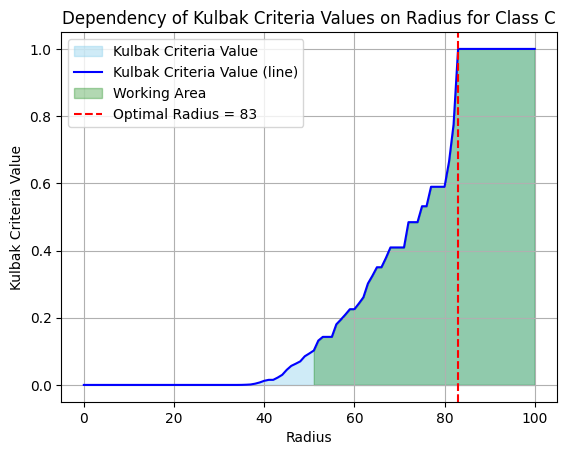

Class  D
Is working area | radius | criteria value | d1 | beta
True 0 0.18041912652430314 0.64 0.0
True 1 0.209436569008623 0.68 0.0
True 2 0.26078499423227786 0.74 0.0
True 3 0.32492562745455617 0.8 0.0
True 4 0.40914680094099404 0.86 0.0
True 5 0.44417245086299173 0.88 0.0
True 6 0.5897198254969898 0.94 0.0
True 7 0.5897198254969898 0.94 0.0
True 8 1.0 1.0 0.0
True 9 1.0 1.0 0.0
True 10 1.0 1.0 0.0
True 11 1.0 1.0 0.0
True 12 1.0 1.0 0.0
True 13 1.0 1.0 0.0
True 14 1.0 1.0 0.0
True 15 1.0 1.0 0.0
True 16 1.0 1.0 0.0
True 17 1.0 1.0 0.0
True 18 1.0 1.0 0.0
True 19 1.0 1.0 0.0
True 20 1.0 1.0 0.0
True 21 1.0 1.0 0.0
True 22 1.0 1.0 0.0
True 23 1.0 1.0 0.0
True 24 1.0 1.0 0.0
True 25 1.0 1.0 0.0
True 26 1.0 1.0 0.0
True 27 1.0 1.0 0.0
True 28 1.0 1.0 0.0
True 29 1.0 1.0 0.0
True 30 1.0 1.0 0.0
True 31 1.0 1.0 0.0
True 32 1.0 1.0 0.0
True 33 1.0 1.0 0.0
True 34 1.0 1.0 0.0
True 35 1.0 1.0 0.0
True 36 1.0 1.0 0.0
True 37 1.0 1.0 0.0
True 38 1.0 1.0 0.0
True 39 1.0 1.0 0.0
True 40 1.0 1.0 

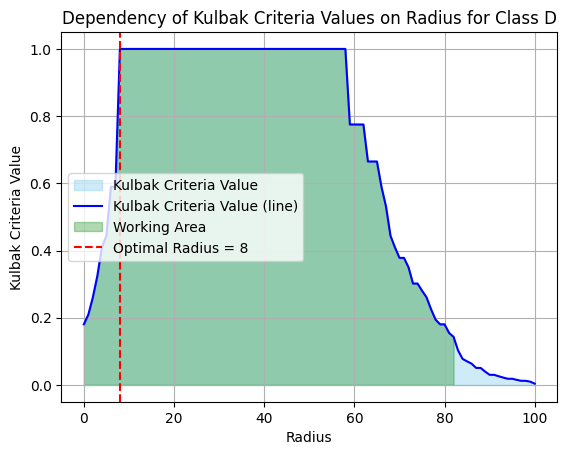

Optimal radius for 2 classes on the left: [72, 67]
Optimal radius for 2 classes on the right: [83, 8]
Class name | Belonging Function Value
A 	   | 0.3575
B 	   | -0.251044776119403
C 	   | -0.19469879518072294
D 	   | 0.12
Class name | Belonging Function Value
A 	   | 0.3866666666666667
B 	   | -0.2740298507462687
C 	   | -0.1946987951807229
D 	   | 0.19
Class name | Belonging Function Value
A 	   | 0.3247222222222222
B 	   | -0.2528358208955224
C 	   | -0.19060240963855424
D 	   | 0.0575
Class name | Belonging Function Value
A 	   | 0.1813888888888889
B 	   | -0.11731343283582088
C 	   | -0.1879518072289157
D 	   | -0.255
Class name | Belonging Function Value
A 	   | 0.20194444444444445
B 	   | -0.19910447761194028
C 	   | -0.19542168674698795
D 	   | 0.1175
Class name | Belonging Function Value
A 	   | 0.32333333333333336
B 	   | -0.2525373134328358
C 	   | -0.18265060240963862
D 	   | 0.04
Class name | Belonging Function Value
A 	   | 0.37611111111111106
B 	   | -0.2465671641791044

In [84]:
# Calculate the average value along the axis 1 and compare with boundary value
BV1 = create_etalon_vector(X_left)
BV2 = create_etalon_vector(X_right)
print("Etalon vectors for left node:")
print(BV1)
print("Etalon vectors for right node:")
print(BV2)
radius1 = find_class_optimal_radius(BV1, X_left, root.left.classes)
radius2 = find_class_optimal_radius(BV2, X_right, root.right.classes)
print("Optimal radius for 2 classes on the left:", radius1)
print("Optimal radius for 2 classes on the right:", radius2)
exam_algorithm(image, class_colors, class_block_size, delta1, delta2, 
               EV1, EV2, BV1, BV2, radius1, radius2, root.left.classes,
               root.right.classes)